<a href="https://colab.research.google.com/github/appleyuchi/TPU_GPU_Code/blob/master/Keras_Fashion_MNIST%E8%87%AA%E5%B7%B1%E6%B3%A8%E9%87%8A%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Fashion MNIST with Keras and TPUs

## Overview

In this example, you can try out using tf.keras and Cloud TPUs to train a model on the fashion MNIST dataset. The model trains for 10 epochs on Cloud TPU and takes approximately 2 minutes to run.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this Colab, you will learn how to:
*   Code for a standard conv-net that has 3 layers with drop-out and batch normalization between each layer in Keras.
*   Create and compile the model under a distribution strategy in order ot use TPUs.
*   Run a prediction to see how well the model can predict fashion categories and output the result.

## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

## Data, model, and training

Begin by downloading the fashion MNIST dataset using `tf.keras.datasets`, as shown below.

In [0]:
import tensorflow as tf
import numpy as np

import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
import pandas as pd

np.set_printoptions(threshold=2000)#全部输出 
pd.set_option('display.max_colwidth',2000)#全部输出 
pd.set_option('max_colwidth',2000)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)


import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

#获取train和validation
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#增加一个张量维度
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test,  -1)

# 根据下面笔记中的记载
# https://blog.csdn.net/appleyuchi/article/details/102000544
# tensorflow默认channel在后面，
# 所以上面增加的是通道维度
# 图像是4D张量（samples,height,width,channels）

Tensorflow version 1.14.0


### Define the model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

In [0]:
# 神经网络结构
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

### Train on the TPU

To begin training, construct the model on the TPU and then compile it.

In [0]:
import os

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.65.28.98:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9485688305093099524)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3351285766462313011)
INFO:tensorflow:*** Av

### Check the results (inference)

Now that you are done training, see how well the model can predict fashion categories!

images.dim (16, 28, 28, 1)
n= 16
predictions= [[1.96307953e-11 1.79005699e-09 5.45655925e-12 5.18960500e-11
  3.39522403e-11 3.81144059e-06 2.17763585e-11 2.38712528e-06
  7.41959050e-10 9.99993801e-01]
 [3.30372190e-04 1.53862900e-09 9.99650598e-01 8.02747309e-08
  1.02141375e-05 5.93606631e-09 8.74055695e-06 4.23723445e-10
  3.06908254e-09 5.30010835e-09]
 [4.84554462e-16 1.00000000e+00 8.57000308e-18 3.51809375e-15
  8.07612299e-17 1.82508732e-14 1.59978623e-18 1.14215668e-17
  1.23873283e-14 3.51057294e-15]
 [1.45727587e-13 1.00000000e+00 2.32089590e-15 1.34665044e-12
  2.73998963e-14 1.16450447e-12 3.23846170e-15 2.39190449e-14
  5.49830689e-13 6.47049081e-12]
 [3.21322083e-02 1.23721877e-08 4.59819828e-04 8.70906933e-06
  1.13600523e-04 6.46502940e-08 9.67285216e-01 7.29158671e-08
  9.99559546e-09 1.66196415e-07]
 [1.02615026e-11 1.00000000e+00 1.97436224e-13 1.39422198e-11
  1.99918012e-12 1.62766592e-10 4.00351681e-14 1.37222234e-14
  1.60219824e-11 1.43911250e-12]
 [9.34538548

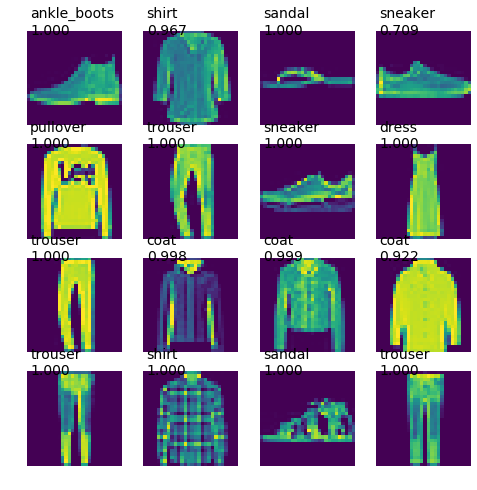

In [19]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover',
               'dress', 'coat', 'sandal', 'shirt', 
               'sneaker', 'bag', 'ankle_boots']
#总共１０个类别

#上面是使用TPU模型训练,下面是使用CPU模型

cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')#加载模型

from matplotlib import pyplot
%matplotlib inline

print("images.dim",x_test[:16].shape)
def plot_predictions(images, predictions):
  n = images.shape[0]
  print("n=",n)
  nc = int(np.ceil(n / 4))#ceil的意思是获取大于该数的最小整数
#   nc的意思是:number of column
  f, axes = pyplot.subplots(nc, 4)

  print("predictions=",predictions)

#   下面这个for循环产生的是每个图的坐标
  for i in range(nc * 4):
    y = i // 4#取商
    x = i % 4#取余数
    # i=4*y+x
    axes[x, y].axis('off')#关闭所有坐标轴线
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    #哪一类的概率最大,就认为是哪一类
    confidence = np.max(predictions[i])#置信度

    print("i=",i)
    #下面这个if一般情况下是进不去的
    if i > n:
      continue
    axes[x, y].imshow(images[i])# 显示图片
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)#显示最终的预测信息

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]),cpu_model.predict(x_test[:16]))
# squeeze的意思是去掉一个张量维度,通常,squeeze去掉的是第一个维度,这里去掉的是samples维度